In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/TimeSeriesApp

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
import xarray as xr
import geopandas as gpd
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import pickle
import matplotlib.dates as mdates

In [ ]:
import pandas as pd

# Define the path and filename for the dataset
data_file_path = './Modis/'
data_filename = 'LebanonCSV.csv'

# Load the dataset into a dataframe
snow_cover_data = pd.read_csv(data_file_path + data_filename, index_col=0, decimal='.')

# Convert Day of Year (DOY) indices into datetime format for each year in the dataset
# Each column in the dataframe corresponds to a year, and the index values represent the day of the year
# The datetime conversion results in a matrix of dates corresponding to each year and day combination
date_matrix = pd.DataFrame(
    [pd.to_datetime(snow_cover_data.index - 1, unit='D', origin=str(year)) for year in snow_cover_data.columns]
).transpose()
date_matrix.index = snow_cover_data.index
date_matrix.columns = snow_cover_data.columns

# Convert the matrix structure into a single series by stacking
# This results in a series of dates and a series of snow cover fractions (scf)
dates_series = date_matrix.transpose().stack(dropna=False)
scf_series = snow_cover_data.transpose().stack(dropna=False)

# Combine the dates and scf series into a single dataframe
snow_cover_dataframe = pd.concat([dates_series, scf_series], axis=1, keys=['dates', 'snow_cover_fraction'])
snow_cover_dataframe.dropna(inplace=True)

# Adjust the datetime index to match the Uerra convention, which is 10h
snow_cover_dataframe.index = [date.replace(hour=10) for date in snow_cover_dataframe['dates']]

# Drop the dates column
snow_cover_dataframe.drop('dates', axis=1, inplace=True)

# Remove rows after the date 2022-07-31
cutoff_date = pd.Timestamp(2022, 7, 31, 10)
snow_cover_dataframe = snow_cover_dataframe[snow_cover_dataframe.index <= cutoff_date]


# Display the first 5 elements of the dataset
snow_cover_dataframe.head()

,snow_cover_fraction
2001-01-01 10:00:00,0.106
2001-01-02 10:00:00,0.106
2001-01-03 10:00:00,0.103
2001-01-04 10:00:00,0.096
2001-01-05 10:00:00,0.079


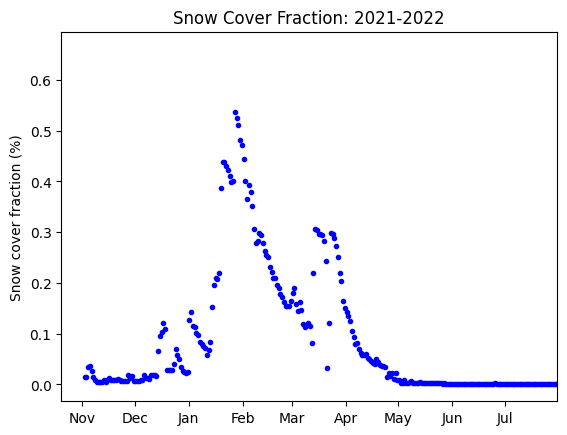

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date

# Extract observation dates and snow cover fractions from the dataframe
observation_dates = snow_cover_dataframe.index
snow_cover_fractions = snow_cover_dataframe['snow_cover_fraction']

# Plot snow cover fractions against observation dates
plt.plot(observation_dates, snow_cover_fractions, marker='.', linestyle='none', color='blue', label='Snow Cover Fraction')

# Set the x-axis limits
start_date = date(2021, 10, 20)
end_date = date(2022, 7, 31)
plt.xlim([start_date, end_date])

# Set the title and y-axis label
plt.title('Snow Cover Fraction: 2021-2022')
plt.ylabel('Snow cover fraction (%)')

# Configure x-axis to show months
current_axis = plt.gca()
current_axis.xaxis.set_major_locator(mdates.MonthLocator())
current_axis.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Display the plot
plt.show()

Text(0.5, 1.0, 'Mean ERA-5 land snow depth')

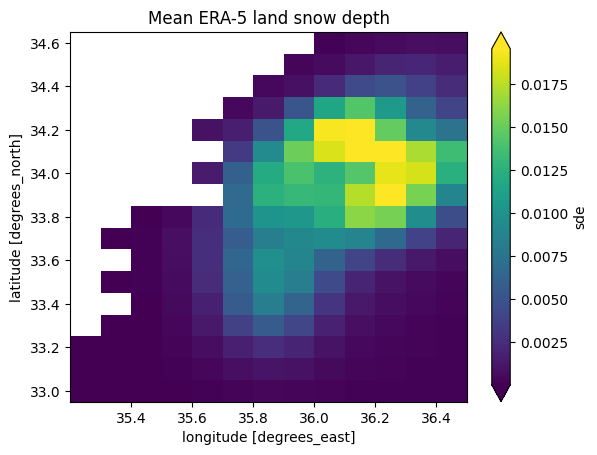

In [ ]:
import xarray as xr

# Lazily load all HS netcdf from 2000 onward
snow_depth_dataframe = xr.open_mfdataset('./DataExport/Lebanon-Snow-Cover-Data/*.nc')
#cropped_snow_depth_dataframe = snow_depth_dataframe.sel(latitude=slice(33,34.7,),longitude=slice(32,36.7))

# Map mean snow depth of the entire dataset
snow_depth_dataframe.sde.mean(dim='time').plot(robust=True)
plt.title('Mean ERA-5 land snow depth')

In [ ]:
import numpy as np
# create datesSel vector containing matching dates from both datasets

datesSel = list(set(snow_cover_dataframe.index.values).intersection(snow_depth_dataframe.time.values))
datesSel.sort()
#print("Modis = " ,  Y.index.values)
#print("UERRA =", ds.time.values)
# reduce UERRA dataset to these dates
dsSel = snow_depth_dataframe.sel(time=datesSel)
# Make X array with predictors
X = dsSel['sde'].values.reshape(len(datesSel),-1)
# remove nodata [TODO: APPLY MODIS AOI MASK]
ix = np.all(np.isnan(X),axis=0)
# This is the array of training data (snow depth of every cell)
X = X[:,~ix]
# This is the array of target values (snow cover fraction)
y = snow_cover_dataframe.loc[datesSel].snow_cover_fraction

print('X dimensions:',X.shape)
print('y dimensions:',y.shape)

X dimensions: (5776, 168)
y dimensions: (5776,)


<ipython-input-9-593a52c893a0>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  combined_sde = pd.Series(index=y.index)


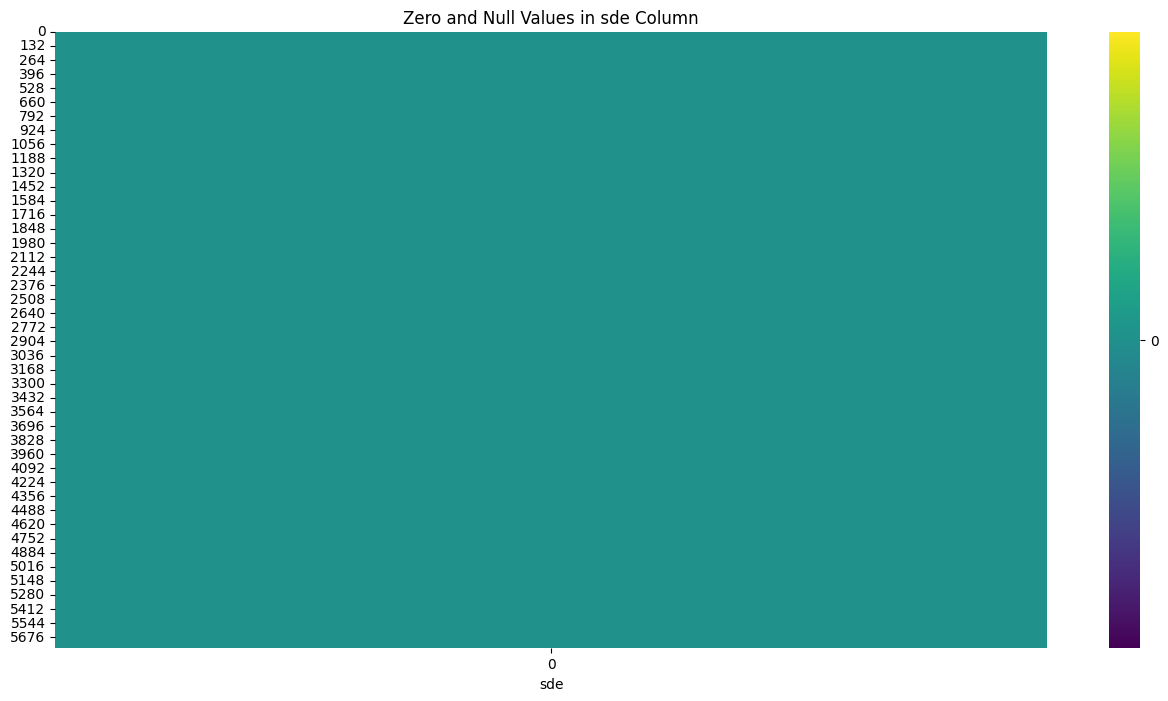

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Series with the same shape as df.sde
combined_sde = pd.Series(index=y.index)

# Mark NaNs with 2
combined_sde[y.isna()] = 2

# Mark zeros with 1
combined_sde[y < 0] = 1

# Fill remaining spots with 0
combined_sde.fillna(0, inplace=True)

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(combined_sde.values.reshape(-1, 1), cbar=True, cmap='viridis', cbar_kws={'ticks': [0, 1, 2]})
plt.title('Zero and Null Values in sde Column')
plt.xlabel('sde')
plt.show()

In [ ]:
print("Percentage of below 0 values in the dataset: {}%".format(round(((y.isna().sum() + (y < 0).sum())/y.shape[0])*100, 4)))

Percentage of below 0 values in the dataset: 0.0%


In [ ]:
from sklearn.ensemble import RandomForestRegressor

def impute_with_rf_and_similar_days(series):
    imputed_series = series.copy()
    rf = RandomForestRegressor(n_estimators=100)
    global_mean = series.mean()  # Calculate the global mean to use for imputation if needed

    for idx, value in series.items():
        if pd.isnull(value):
            # Extract similar days (same day and month) from other years
            similar_dates = [date for date in series.index if date.month == idx.month and date.day == idx.day and date != idx]
            similar_values = series.loc[similar_dates]

            # If there are missing values on similar days, expand the window (e.g., +/- 1 day)
            if similar_values.isna().any():
                expanded_dates = [date for date in series.index if (0 <= (date - idx).days <= 1) and date != idx]
                similar_values = series.loc[expanded_dates]

            # Remove any NaNs in the similar values
            valid_similar_values = similar_values.dropna()

            # If there are enough samples to train the model
            if len(valid_similar_values) > 0:
                # Train the RandomForest using the years of the similar days as features
                X_train = np.array([date.year for date in valid_similar_values.index]).reshape(-1, 1)
                y_train = valid_similar_values.values
                rf.fit(X_train, y_train)

                # Predict the missing value using the year of the missing value as the feature
                X_pred = np.array([[idx.year]])
                imputed_value = rf.predict(X_pred)

                # Assign the predicted value
                imputed_series[idx] = imputed_value[0]
            else:
                # If there are no valid similar days, try interpolation
                imputed_series.interpolate(method='time', inplace=True)
                # If interpolation fails (edge cases), use global mean
                if pd.isnull(imputed_series[idx]):
                    imputed_series[idx] = global_mean

    return imputed_series

In [ ]:
y_imputed = impute_with_rf_and_similar_days(y)

In [ ]:
data = y_imputed.to_frame()

data.index = pd.to_datetime(data.index.date)

In [ ]:
# Reset the index to move the dates to a column
# data_reset = data.reset_index()

# Rename the index column to 'dates'
# data_reset.rename(columns={'index': 'dates'}, inplace=True)

# Save the DataFrame to a CSV file
# data_reset.to_csv('data_2001_2022.csv', index=False)

In [ ]:
# Checking for missing dates in the dataset
date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
missing_dates = date_range.difference(data.index)

# Displaying the missing dates
missing_dates

DatetimeIndex(['2001-01-31', '2001-03-31', '2001-05-31', '2001-06-16',
               '2001-06-17', '2001-06-18', '2001-06-19', '2001-06-20',
               '2001-06-21', '2001-06-22',
               ...
               '2021-10-27', '2021-10-28', '2021-10-29', '2021-10-30',
               '2021-10-31', '2021-11-01', '2021-12-31', '2022-01-31',
               '2022-03-31', '2022-05-31'],
              dtype='datetime64[ns]', length=2105, freq=None)

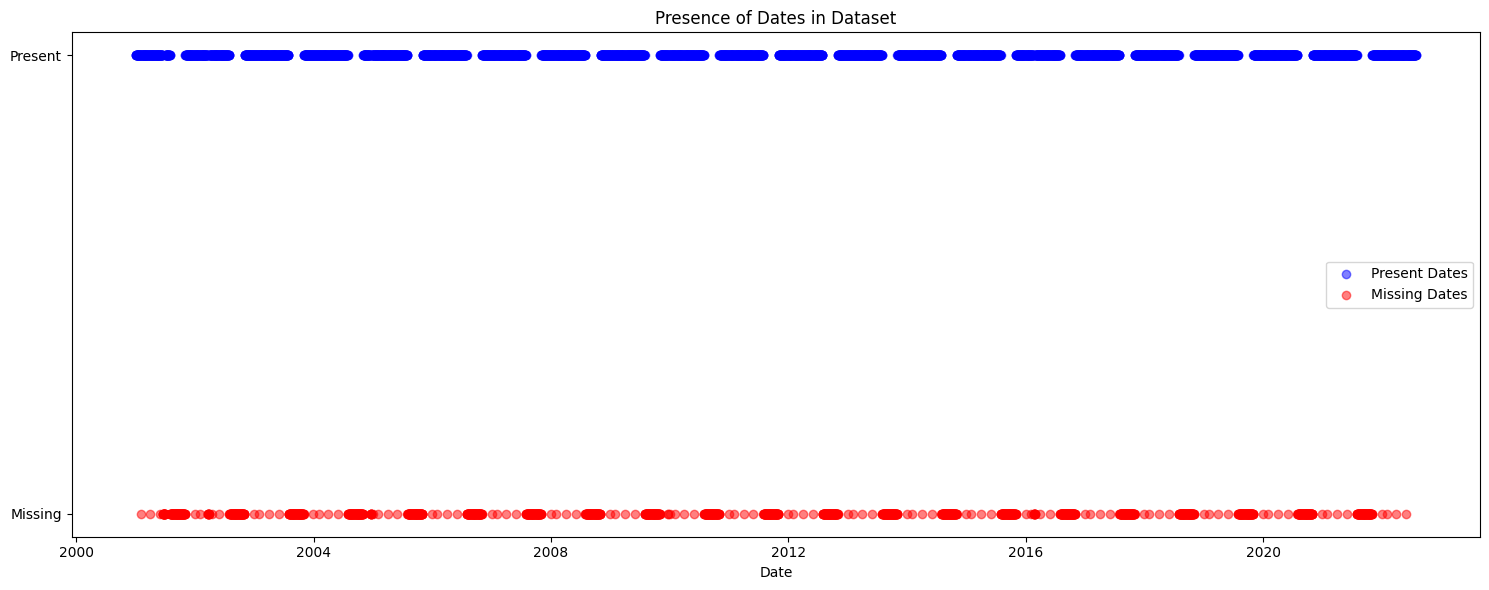

In [ ]:
import matplotlib.pyplot as plt

# Plotting the filled dates and missing dates in a graph
plt.figure(figsize=(15, 6))

# Marking the dates present in the dataset
plt.scatter(data.index, [1] * len(data), color='blue', label='Present Dates', alpha=0.5)

# Marking the missing dates
plt.scatter(missing_dates, [0] * len(missing_dates), color='red', label='Missing Dates', alpha=0.5)

plt.xlabel('Date')
plt.yticks([0, 1], ['Missing', 'Present'])
plt.title('Presence of Dates in Dataset')
plt.legend()
plt.tight_layout()
plt.show()

Check the gap between missing days (how long is the biggest one and during
which season)

from the missing 3000 values check how many are during the summer

In [ ]:
# Step 1: Calculate the Gap Between Missing Days
missing_dates_diff = missing_dates.to_series().diff().dt.days - 1
max_gap = missing_dates_diff.max()
max_gap_index = missing_dates_diff.idxmax()  # Timestamp index of the maximum gap

# Find the integer position of max_gap_index in missing_dates
position = missing_dates.get_loc(max_gap_index)

# Now use integer position for slicing to get the max gap period
max_gap_period = missing_dates[position:position + 2]

# Identify the season of the largest gap
seasons = {'Spring': (pd.Timestamp(year=missing_dates.year[0], month=3, day=21), pd.Timestamp(year=missing_dates.year[0], month=6, day=20)),
           'Summer': (pd.Timestamp(year=missing_dates.year[0], month=6, day=21), pd.Timestamp(year=missing_dates.year[0], month=9, day=22)),
           'Autumn': (pd.Timestamp(year=missing_dates.year[0], month=9, day=23), pd.Timestamp(year=missing_dates.year[0], month=12, day=20)),
           'Winter': (pd.Timestamp(year=missing_dates.year[0], month=12, day=21), pd.Timestamp(year=missing_dates.year[0] + 1, month=3, day=20))}

max_gap_season = next(season for season, (start, end) in seasons.items() if start <= max_gap_period[0] <= end)

# Step 2: Count Missing Days in Summer for Each Year
summer_missing_count = 0
for year in range(data.index.year.min(), data.index.year.max() + 1):
    summer_start = pd.Timestamp(year=year, month=6, day=21)
    summer_end = pd.Timestamp(year=year, month=9, day=22)
    summer_range = pd.date_range(start=summer_start, end=summer_end)
    summer_missing = missing_dates.intersection(summer_range)
    summer_missing_count += len(summer_missing)

In [ ]:
print(f"Largest gap: {int(max_gap)} days during {max_gap_season}")
print(f"Total number of missing summer days: {summer_missing_count} out of {len(missing_dates)}")

Largest gap: 60 days during Spring
Total number of missing summer days: 1151 out of 2105


In [ ]:
# Step 3: Fill Missing Summer Days with 0, Interpolate Others for Each Year
data_interpolated = data.reindex(date_range)

for year in range(data.index.year.min(), data.index.year.max() + 1):
    summer_start = pd.Timestamp(year=year, month=6, day=21)
    summer_end = pd.Timestamp(year=year, month=9, day=22)
    summer_range = pd.date_range(start=summer_start, end=summer_end)
    summer_missing = missing_dates.intersection(summer_range)
    data_interpolated.loc[summer_missing] = 0

# Interpolate other missing days
data_interpolated = data_interpolated.interpolate(method='linear')

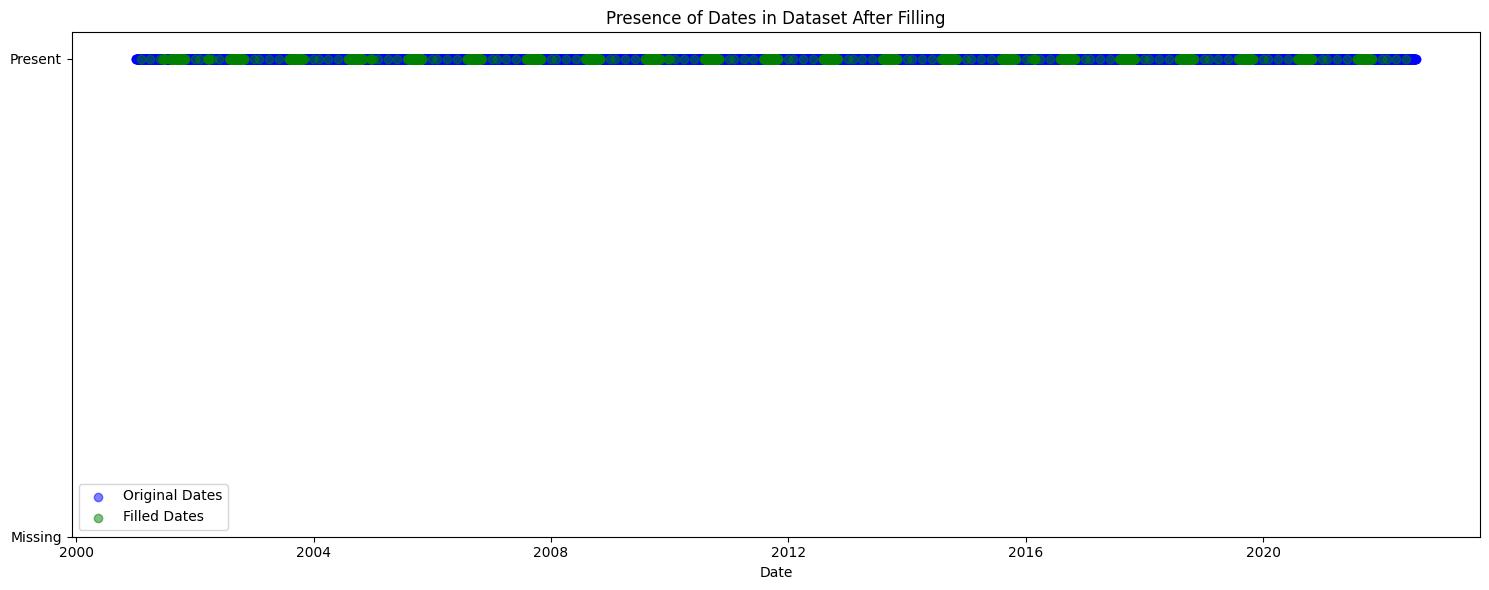

In [ ]:
# Filling missing dates by linear interpolation
# data_interpolated = data.reindex(date_range).interpolate(method='linear')

# Checking if all missing dates are filled
filled_dates = data_interpolated.index.difference(data.index)

# Plotting the graph again with the filled data
plt.figure(figsize=(15, 6))

# Marking the original dates
plt.scatter(data.index, [1] * len(data), color='blue', label='Original Dates', alpha=0.5)

# Marking the filled dates
plt.scatter(filled_dates, [1] * len(filled_dates), color='green', label='Filled Dates', alpha=0.5)

plt.xlabel('Date')
plt.yticks([0, 1], ['Missing', 'Present'])
plt.title('Presence of Dates in Dataset After Filling')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# Function to calculate weights
def get_weights(num_years):
    total_weight = sum(range(1, num_years + 1))
    return [i / total_weight for i in range(1, num_years + 1)][::-1]

# Number of years to look back
lookback_years = 5

# Last date in the data
last_date = data_interpolated.index[-1]

# Calculate the remaining days in the year
remaining_days = pd.date_range(start=last_date + pd.Timedelta(days=1), end=pd.Timestamp(year=last_date.year, month=12, day=31))

# DataFrame to store the extended data
extended_forecast = pd.DataFrame(index=remaining_days, columns=['snow_cover_fraction'])

for date in extended_forecast.index:
    historical_values = []
    weights = []
    for i in range(1, lookback_years + 1):
        historical_date = pd.Timestamp(year=date.year - i, month=date.month, day=date.day)
        # Check if the historical date exists in the data
        if historical_date in data_interpolated.index:
            historical_values.append(data_interpolated.loc[historical_date, 'snow_cover_fraction'])
            weights.append(i)  # Weight by the year
        else:
            print(f"No data for historical date: {historical_date}")

    # Calculate weighted average if historical values are available
    if historical_values:
        weights = np.array(weights) / sum(weights)
        weighted_avg = np.dot(historical_values, weights)
        extended_forecast.loc[date, 'snow_cover_fraction'] = weighted_avg
    else:
        print(f"No historical data available for forecast date: {date}")
        extended_forecast.loc[date, 'snow_cover_fraction'] = np.nan

# Check if any forecasted values were calculated
print("Number of non-null forecasted values:", extended_forecast['snow_cover_fraction'].notnull().sum())

# Combine the existing and forecasted data
extended_data = pd.concat([data_interpolated, extended_forecast])
extended_data.tail(155)


Number of non-null forecasted values: 154


,snow_cover_fraction
2022-07-30,0.0
2022-07-31,0.0
2022-08-01,0.0
2022-08-02,0.0
2022-08-03,0.0
...,...
2022-12-27,0.188
2022-12-28,0.166267
2022-12-29,0.1812
2022-12-30,0.169333


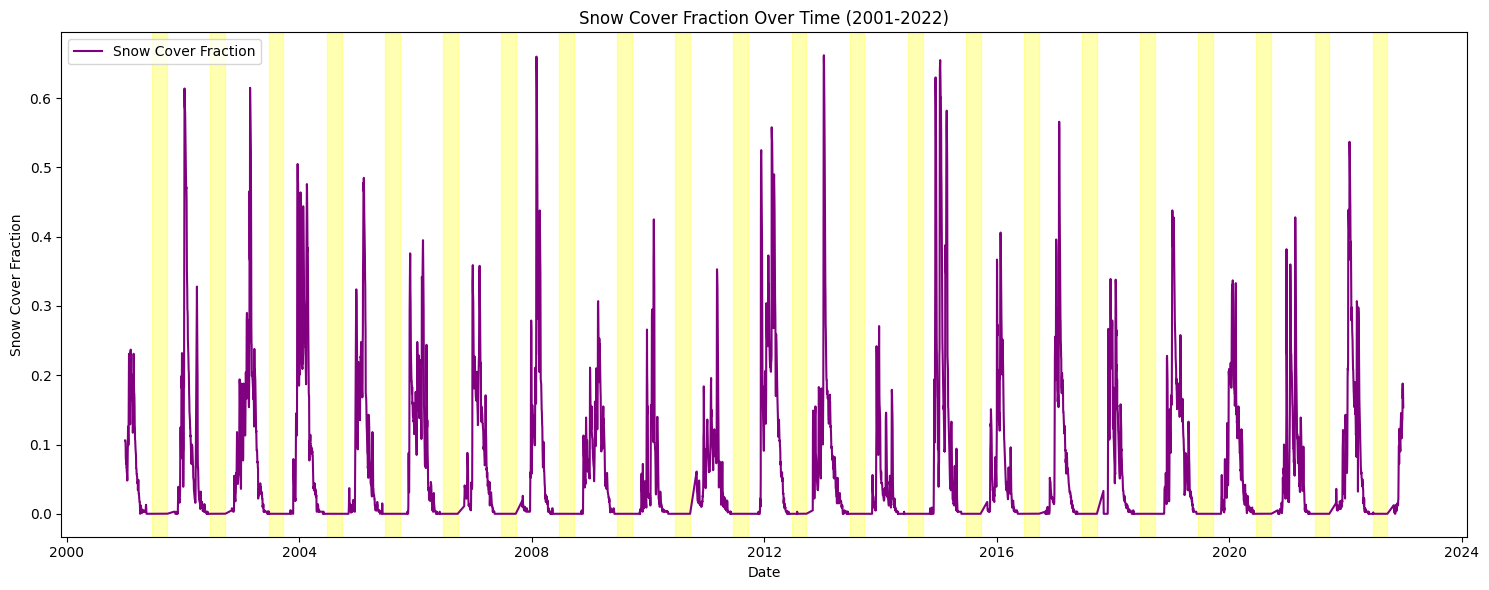

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'extended_data' is your DataFrame and it has a DateTime index
# Define the summer period for each year in your dataset
start_month, start_day = 6, 21  # June 21
end_month, end_day = 9, 22      # September 22

summer_periods = []

for year in range(extended_data.index.year.min(), extended_data.index.year.max() + 1):
    summer_start = pd.Timestamp(year=year, month=start_month, day=start_day)
    summer_end = pd.Timestamp(year=year, month=end_month, day=end_day)
    if summer_start in extended_data.index and summer_end in extended_data.index:
        summer_periods.append((summer_start, summer_end))

# Plotting the whole dataset
plt.figure(figsize=(15, 6))
plt.plot(extended_data, label='Snow Cover Fraction', color='purple')

# Highlighting summer days
for start, end in summer_periods:
    plt.axvspan(start, end, color='yellow', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Snow Cover Fraction')
plt.title('Snow Cover Fraction Over Time (2001-2022)')
plt.legend()
plt.tight_layout()
plt.show()


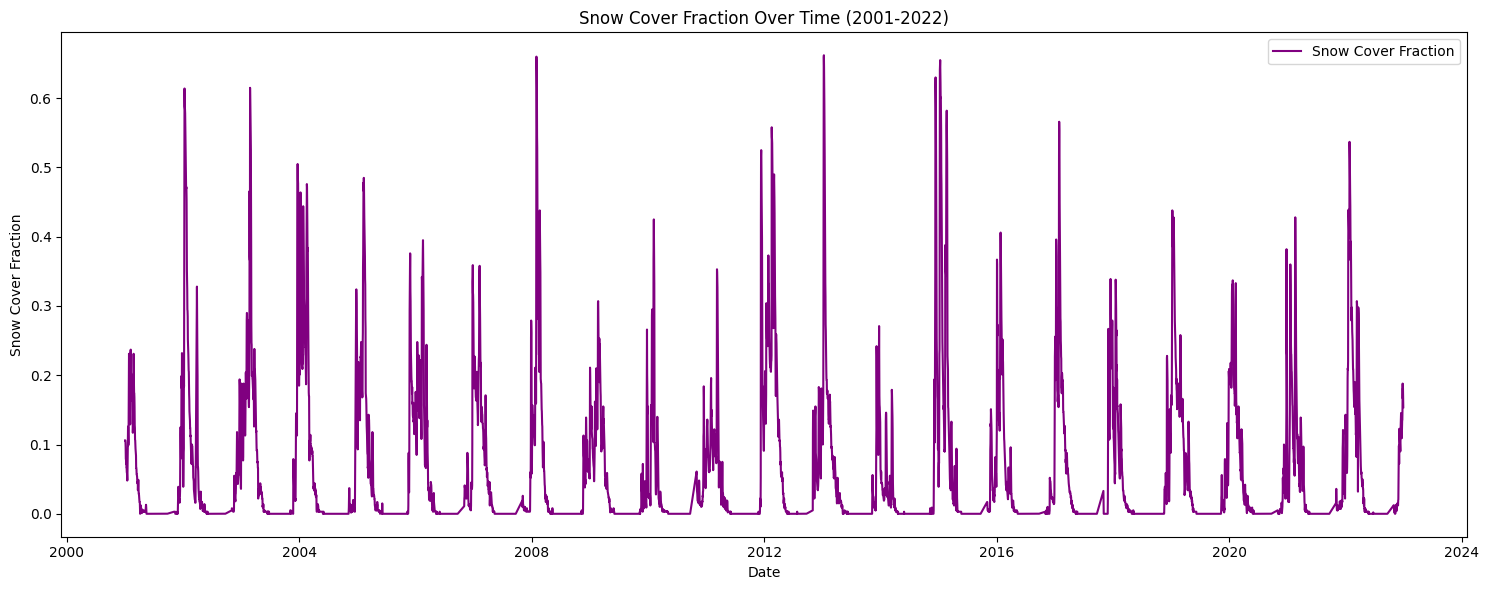

In [ ]:
import matplotlib.pyplot as plt

# Plotting the whole dataset
plt.figure(figsize=(15, 6))
plt.plot(extended_data, label='Snow Cover Fraction', color='purple')
plt.xlabel('Date')
plt.ylabel('Snow Cover Fraction')
plt.title('Snow Cover Fraction Over Time (2001-2022)')
plt.legend()
plt.tight_layout()
plt.show()


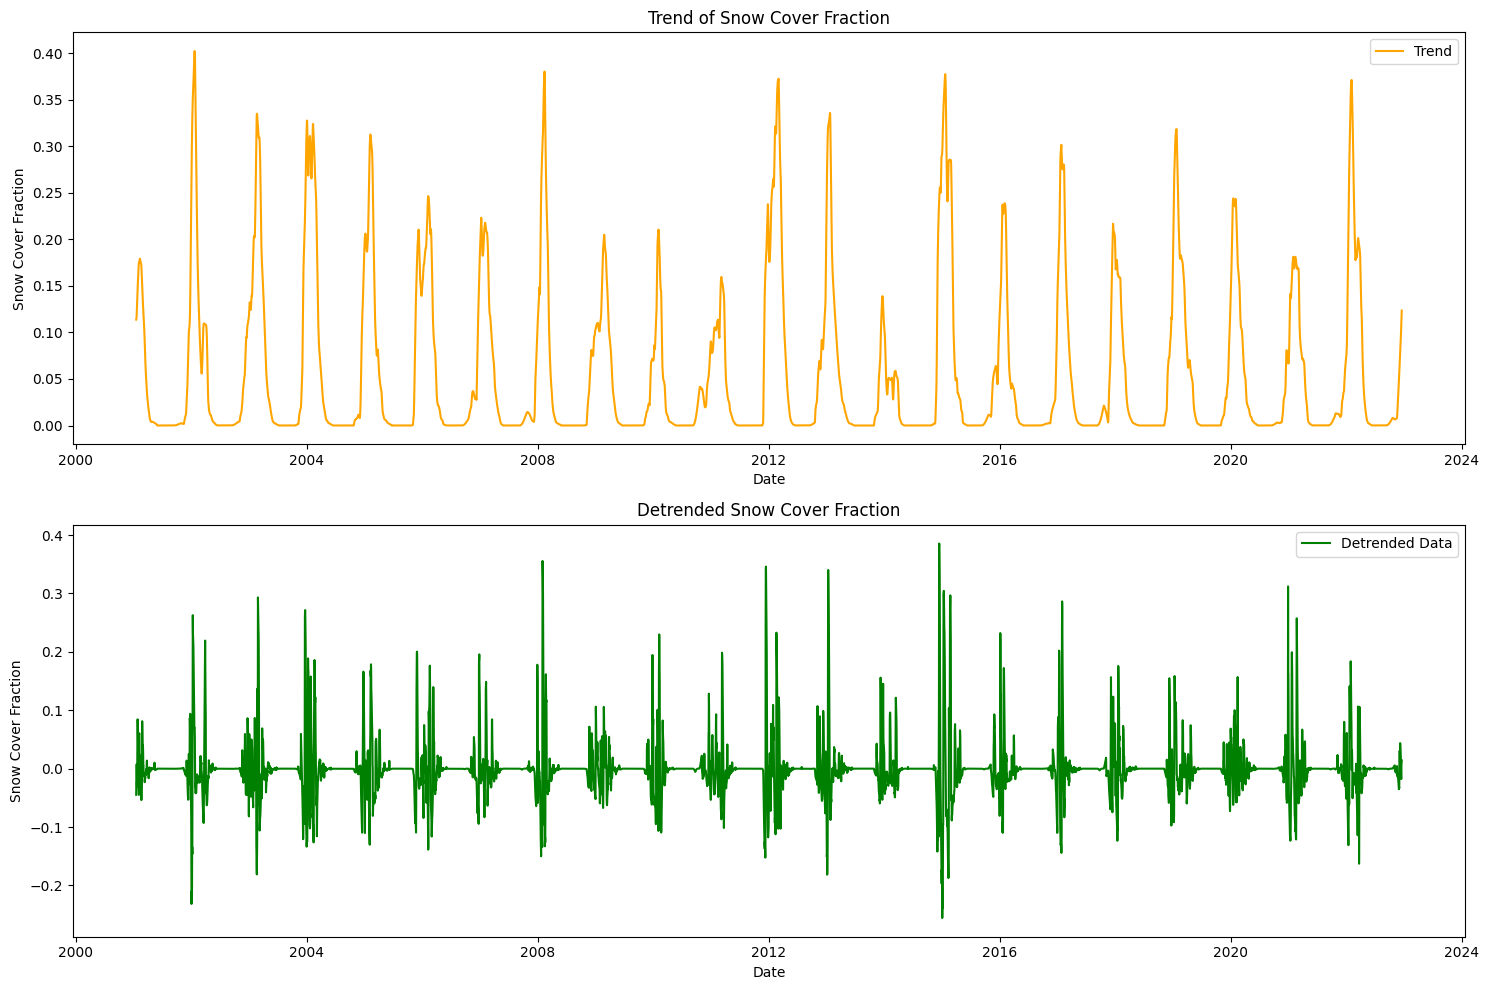

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the data to extract the trend
decomposition = seasonal_decompose(extended_data, model='additive', period=30)
trend = decomposition.trend

# Detrending the data by subtracting the trend from the original data
detrended_data = extended_data['snow_cover_fraction'] - trend

# Dropping NaN values for plotting
trend = trend.dropna()
detrended_data = detrended_data.dropna()

# Plotting the trend and the detrended data
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Plotting the trend
axes[0].plot(trend, label='Trend', color='orange')
axes[0].set_title('Trend of Snow Cover Fraction')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Snow Cover Fraction')
axes[0].legend()

# Plotting the detrended data
axes[1].plot(detrended_data, label='Detrended Data', color='green')
axes[1].set_title('Detrended Snow Cover Fraction')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Snow Cover Fraction')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
# Import your chosen model here

def count_leap_years(years):
    """ Counts the number of leap years in a given array of years. """
    return sum(1 for year in years if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0))

# Convert the trend data to an array for easier manipulation
trend_array = trend.dropna()

# Prepare data for rolling window approach
X, y = [], []
start_year = trend_array.index.year[0]
for start_idx in range(len(trend_array)):
    # Adjusting for a 10-year training period
    end_year = start_year + 10
    if end_year > trend_array.index.year[-1]:
        break

    # Count the number of leap years in the 10-year window
    leap_years = count_leap_years(range(start_year, end_year))

    # Adjust the window size to account for leap years in 10 years
    window_size = 10 * 365 + leap_years
    prediction_horizon = 3650 + count_leap_years(range(end_year, end_year + 10))  # 10 years including leap years

    if start_idx + window_size + prediction_horizon > len(trend_array):
        break

    X.append(trend_array[start_idx:start_idx + window_size].to_numpy())
    y.append(trend_array[start_idx + window_size:start_idx + window_size + prediction_horizon].to_numpy())

    start_year += 1

X = np.array(X, dtype=object)
y = np.array(y, dtype=object)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example: Assuming each element in X is a sequence (e.g., list or array)
# Pad the sequences in X so they all have the same length
max_length_X = max(len(sequence) for sequence in X)
max_length_y = max(len(sequence) for sequence in y)
X_padded = pad_sequences(X, maxlen=max_length_X, padding='post', dtype='float32')
y_padded = pad_sequences(y, maxlen=max_length_y, padding='post', dtype='float32')

# Reshape for LSTM: [samples, timesteps, features]
X_lstm = X_padded.reshape((X_padded.shape[0], max_length_X, 1))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Function to create a more complex LSTM model
def create_model(neurons=50, activation='relu', dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(max_length_X, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# Parameters for pseudo grid search
param_grid = {
    'neurons': [50, 100],
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.2, 0.3]
}

# Wrap the model so it can be used by scikit-learn
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=2)

# Grid search for model tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_lstm, y_padded)  # Assuming X and y are your dataset prepared for LSTM

# Best parameters from grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


<ipython-input-70-685f53d94530>:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=2)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Epoch 1/10
1/1 - 3s - loss: 0.0113 - 3s/epoch - 3s/step
Epoch 2/10
1/1 - 1s - loss: 0.0104 - 1s/epoch - 1s/step
Epoch 3/10
1/1 - 1s - loss: 0.0100 - 1s/epoch - 1s/step
Epoch 4/10
1/1 - 1s - loss: 0.0095 - 1s/epoch - 1s/step
Epoch 5/10
1/1 - 1s - loss: 0.0089 - 1s/epoch - 1s/step
Epoch 6/10
1/1 - 1s - loss: 0.0083 - 1s/epoch - 1s/step
Epoch 7/10
1/1 - 2s - loss: 0.0080 - 2s/epoch - 2s/step
Epoch 8/10
1/1 - 2s - loss: 0.0078 - 2s/epoch - 2s/step
Epoch 9/10
1/1 - 2s - loss: 0.0076 - 2s/epoch - 2s/step
Epoch 10/10
1/1 - 2s - loss: 0.0076 - 2s/epoch - 2s/step
Best: nan using {'activation': 'relu', 'dropout_rate': 0.2, 'neurons': 50}


In [ ]:
# Proceed with the best parameters for a more complex forecast
best_model = create_model(neurons=grid_result.best_params_['neurons'],
                          activation=grid_result.best_params_['activation'],
                          dropout_rate=grid_result.best_params_['dropout_rate'])

# Display model summary
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
best_model.fit(X_lstm, y_padded, epochs=10, batch_size=32)

Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 0.0105
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0099
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0094
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0090
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0089
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0085
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0082
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0079
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0077
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0076


In [ ]:
# Assuming you have the correct prediction horizon
prediction_horizon = max_length_y  # Adjust this as per your model's output

# Select the last 5 years of data for testing (adjust according to the prediction horizon)
test_data = trend.last('5Y')[-prediction_horizon:]

In [ ]:
# Check if the last 5 years have enough data, if not, adjust the period
if len(test_data) < prediction_horizon:
    # Adjust the period to match the prediction horizon
    test_data = trend[-prediction_horizon:]

# Pad and reshape the test data
test_data_padded = pad_sequences([test_data.values], maxlen=max_length_X, padding='post', dtype='float32')
test_data_lstm = test_data_padded.reshape((1, max_length_X, 1))

# The true values (y) for evaluation
true_values = test_data.values.reshape((1, prediction_horizon))

# Evaluate the model
model_evaluation = best_model.evaluate(test_data_lstm, true_values, verbose=0)

print("Model Evaluation (Loss) on the selected test data segment:", model_evaluation)


Model Evaluation (Loss) on the selected test data segment: 0.007078454364091158


1/1 [==============================] - 0s 281ms/step


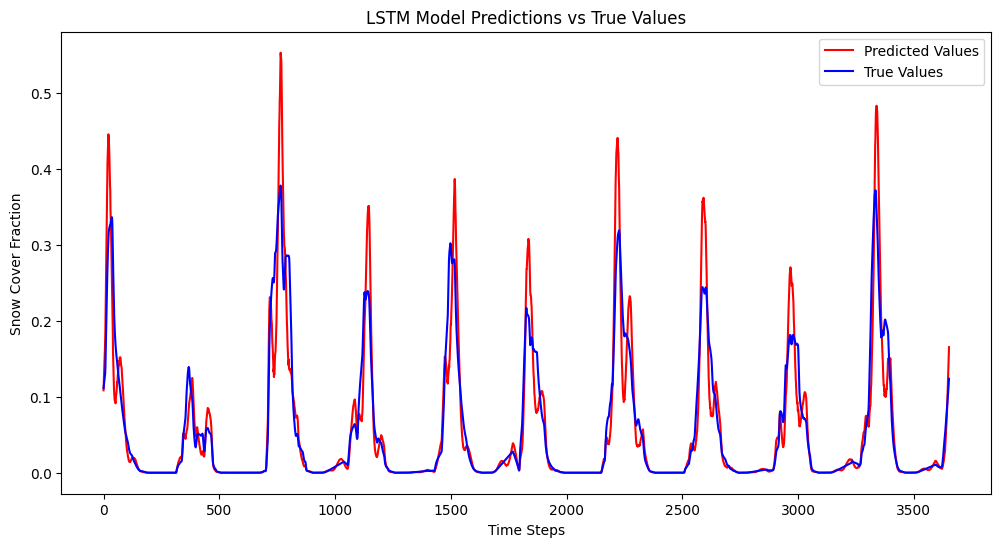

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions for the test data
predictions = best_model.predict(test_data_lstm)

# Flatten the predictions to match the true values' shape
predictions_flat = predictions.flatten()

# Plot the predictions and the true values
plt.figure(figsize=(12, 6))
plt.plot(predictions_flat, label='Predicted Values', color='red')
plt.plot(true_values.flatten(), label='True Values', color='blue')
plt.title('LSTM Model Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Snow Cover Fraction')
plt.legend()
plt.show()


In [ ]:
def nash_sutcliffe_efficiency(true_values, predicted_values):
    """
    Calculate the Nash-Sutcliffe efficiency coefficient.
    :param true_values: Array of true values.
    :param predicted_values: Array of predicted values.
    :return: Nash-Sutcliffe efficiency coefficient.
    """
    mean_observed = np.mean(true_values)
    numerator = np.sum((predicted_values - true_values) ** 2)
    denominator = np.sum((true_values - mean_observed) ** 2)
    return 1 - (numerator / denominator)

# Calculate Nash-Sutcliffe efficiency
nse = nash_sutcliffe_efficiency(true_values.flatten(), predictions_flat)
print(f"Nash-Sutcliffe Efficiency: {nse}")

Nash-Sutcliffe Efficiency: 0.825022502151404


In [ ]:
look_back = 3653
# Sliding window prediction for the next 10 years
predicted = []

# Convert the Pandas Series to a NumPy array
current_batch = trend[-look_back:].to_numpy()
current_batch = current_batch.reshape((1, look_back, 1))

In [ ]:
# Replicate the last five years of data for a ten-year forecast
last_ten_years = trend.last('10Y')

pred_val = []
for i in range(3653): # 10 years * 365 days + 3 (leap years)
    current_pred = model.predict(current_batch)[0]
    predicted.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

if len(pred_val) > 3653:
    pred_val = pred_val.iloc[:3653]

# Generating new dates for the ten-year forecast period
forecast_start_date = last_ten_years.index[-1] + pd.Timedelta(days=1)
forecast_end_date = forecast_start_date + pd.DateOffset(years=10)
forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')[:len(pred_val)]

# Ensure the forecast data aligns with the new dates
forecast_data = pd.Series(data=pred_val.values, index=forecast_dates)

1/1 [==============================] - 0s 56ms/step


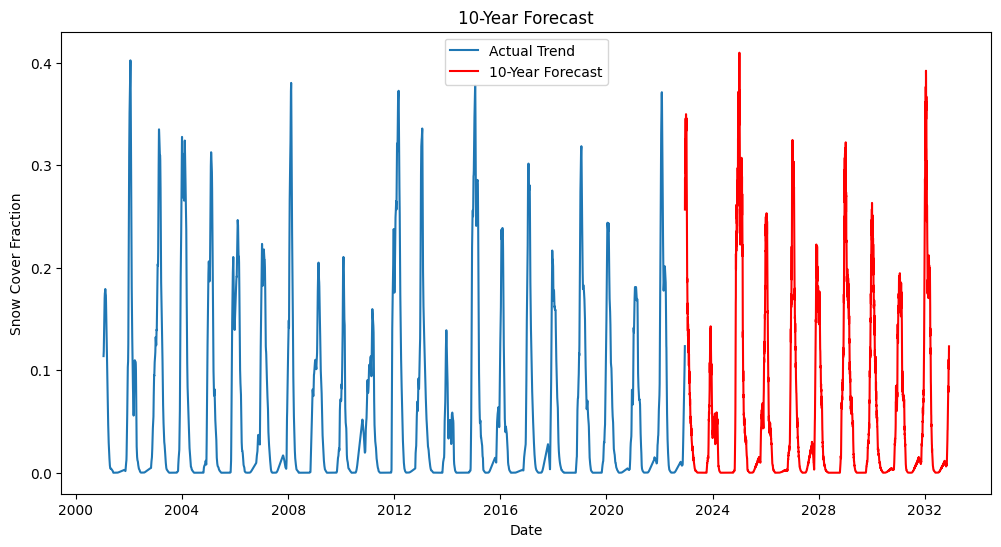

In [ ]:
# Plotting the forecast alongside the actual trend
plt.figure(figsize=(12, 6))
plt.plot(trend.index, trend, label='Actual Trend')
plt.plot(forecast_data.index, forecast_data, label='10-Year Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Snow Cover Fraction')
plt.title('10-Year Forecast')
plt.legend()
plt.show()


In [ ]:
# Save the LSTM model
model.model.save('./lstm_model.h5')

# Combining the original trend data with the forecast data
extended_dataset = pd.concat([trend, forecast_data])
extended_dataset.index.name = 'date'
extended_dataset.name = 'snow_cover_fraction'

# Save the extended dataset as a CSV file
extended_dataset.to_csv('./extended_dataset.csv', header=True)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = './extended_dataset.csv'
trend_data = pd.read_csv(file_path, parse_dates=True)
trend_data.head()

,date,snow_cover_fraction
0,2001-01-16,0.113817
1,2001-01-17,0.114950
2,2001-01-18,0.115783
3,2001-01-19,0.118500
4,2001-01-20,0.123383


## Detrended data prediction

In [ ]:
detrended_data

2001-01-16   -0.044817
2001-01-17    -0.02295
2001-01-18   -0.019783
2001-01-19      0.0075
2001-01-20   -0.014383
                ...   
2022-12-12   -0.013396
2022-12-13   -0.017779
2022-12-14    0.007151
2022-12-15    0.008778
2022-12-16    0.014149
Freq: D, Length: 8005, dtype: object

In [ ]:
detrended_dataframe = detrended_data.to_frame(name='snow_cover_fraction')
detrended_dataframe.head()

,snow_cover_fraction
2001-01-16,-0.044817
2001-01-17,-0.02295
2001-01-18,-0.019783
2001-01-19,0.0075
2001-01-20,-0.014383


In [ ]:
detrended_dataframe.describe()

,snow_cover_fraction
count,8005.0
unique,5588.0
top,0.0
freq,257.0


In [ ]:
# Function to create dataset for GRU
def create_dataset(data, look_back=365):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


In [ ]:
# Create the dataset for GRU
values = detrended_dataframe.values
X, y = create_dataset(values)

In [ ]:
# Splitting data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Reshape input for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
from tensorflow.keras.layers import GRU, Dense, Dropout


# Building the GRU model
model = Sequential(name="GRU")
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 365, 50)           7950      
                                                                 
 dropout (Dropout)           (None, 365, 50)           0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

Epoch 1/3
191/191 [==============================] - 118s 590ms/step - loss: 8.6455e-04 - val_loss: 4.2928e-04
Epoch 2/3
191/191 [==============================] - 65s 342ms/step - loss: 5.0101e-04 - val_loss: 3.6082e-04
Epoch 3/3
191/191 [==============================] - 72s 376ms/step - loss: 4.2780e-04 - val_loss: 4.1005e-04


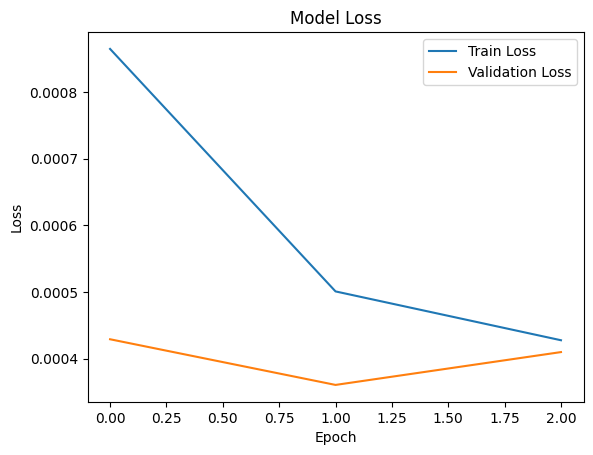

In [ ]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Forecasting future values
future_steps = 365 * 10 + 3
forecast = []
last_input = X_test[-1]


In [ ]:
current_date = detrended_dataframe.index[-1] + pd.Timedelta(days=1)
for i in range(future_steps):
    prediction = model.predict(last_input.reshape(1, -1, 1))[0, 0] #
    forecast.append(prediction)
    last_input = np.roll(last_input, -1)
    last_input[-1] = prediction


1/1 [==============================] - 0s 108ms/step


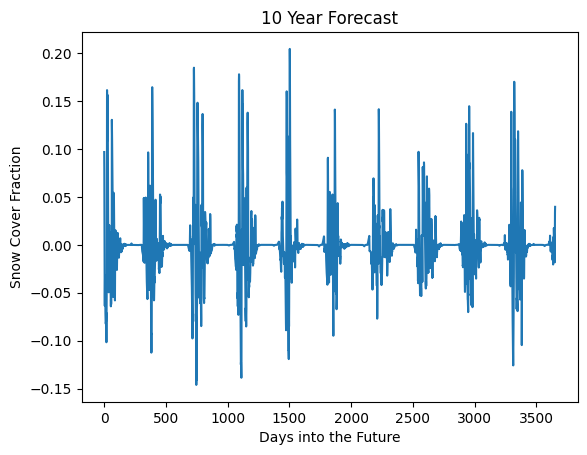

In [ ]:
# Visualizing the forecast
plt.plot(range(len(forecast)), forecast)
plt.title('10 Year Forecast')
plt.ylabel('Snow Cover Fraction')
plt.xlabel('Days into the Future')
plt.show()

In [ ]:
# Replicate the last five years of data for a ten-year forecast
last_ten_years = trend.last('10Y')

# Generating new dates for the ten-year forecast period
forecast_start_date = last_ten_years.index[-1] + pd.Timedelta(days=1)
forecast_end_date = forecast_start_date + pd.DateOffset(years=10)
forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')[:len(forecast)]

# Ensure the forecast data aligns with the new dates
forecast_data = pd.Series(data=forecast, index=forecast_dates)

In [ ]:
# Save the GRU model
model.save('./lb_gru_model.h5')

# Combining the original trend data with the forecast data
extended_dataset = pd.concat([detrended_data, forecast_data])
extended_dataset.index.name = 'date'
extended_dataset.name = 'snow_cover_fraction'

# Save the extended dataset as a CSV file
extended_dataset.to_csv('./Lebanon_extended_dataset_detrended_v1.csv', header=True)

**full lebanese data**

In [ ]:
trend = pd.read_csv('./extended_dataset.csv', index_col='date', parse_dates=True)
detrend = pd.read_csv('./Lebanon_extended_dataset_detrended_v1.csv', index_col='date', parse_dates=True)

In [ ]:
trend.rename(columns={'snow_cover_fraction': 'trend'}, inplace=True)
trend.head()

,trend
date,
2001-01-16,0.113817
2001-01-17,0.114950
2001-01-18,0.115783
2001-01-19,0.118500
2001-01-20,0.123383


In [ ]:
detrend.rename(columns={'snow_cover_fraction': 'detrend'}, inplace=True)
detrend.head()

,detrend
date,
2001-01-16,-0.044817
2001-01-17,-0.022950
2001-01-18,-0.019783
2001-01-19,0.007500
2001-01-20,-0.014383


In [ ]:
merged_df = pd.merge(trend, detrend, left_index=True, right_index=True)
merged_df.head()

,trend,detrend
date,,
2001-01-16,0.113817,-0.044817
2001-01-17,0.114950,-0.022950
2001-01-18,0.115783,-0.019783
2001-01-19,0.118500,0.007500
2001-01-20,0.123383,-0.014383


In [ ]:
merged_df['snow_cover_fraction'] = (merged_df['trend'] + merged_df['detrend']).clip(lower=0)
merged_df.head()

,trend,detrend,snow_cover_fraction
date,,,
2001-01-16,0.113817,-0.044817,0.069
2001-01-17,0.114950,-0.022950,0.092
2001-01-18,0.115783,-0.019783,0.096
2001-01-19,0.118500,0.007500,0.126
2001-01-20,0.123383,-0.014383,0.109


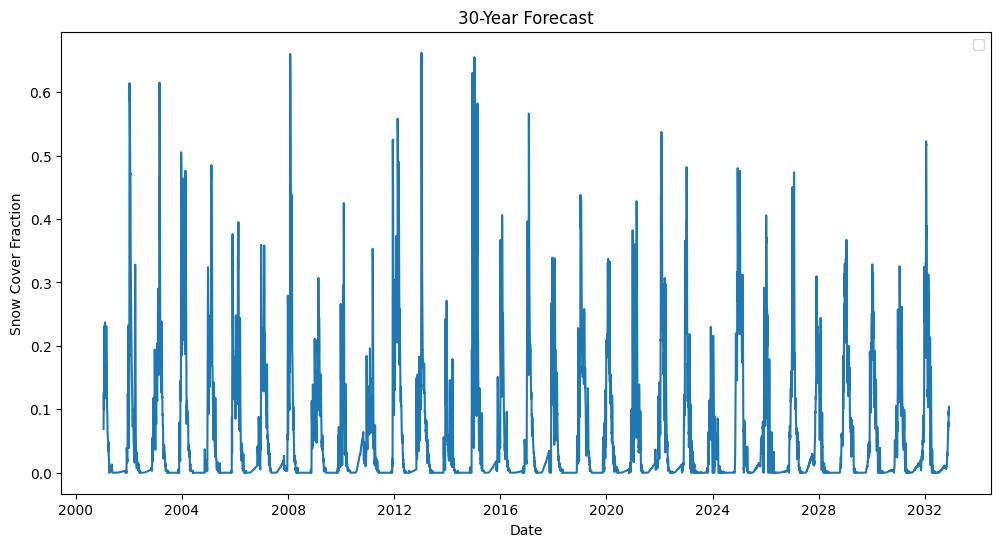

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df.snow_cover_fraction)
plt.xlabel('Date')
plt.ylabel('Snow Cover Fraction')
plt.title('30-Year Forecast')
plt.legend()
plt.show()

In [ ]:
merged_df.to_csv('./Lebanon_merged_dataset.csv', header=True)